In [16]:
from xgboost.sklearn import XGBRegressor

In [17]:
from lightgbm.sklearn import LGBMRegressor

In [18]:
import pandas as pd

data_path = './data/'

train = pd.read_csv(data_path + 'FIFA_train.csv')
test = pd.read_csv(data_path + 'FIFA_test.csv')
submission = pd.read_csv(data_path + 'submission.csv')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression #, Ridge, Lasso
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf

In [20]:
# df = pd.concat([train,test])
# df

1. FIFA_train.csv / FIFA_test.csv
 - id : 선수 고유의 아이디
 - name : 이름
 - age : 나이
 - continent : 선수들의 국적이 포함되어 있는 대륙입니다
 - contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
 - position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
 - prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
 - reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
 - stat_overall : 선수의 현재 능력치 입니다.
 - stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
 - stat_skill_moves : 선수의 개인기 능력치 입니다.
 - value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다


2. submission.csv (제출 파일 형식)
- id : 선수 고유의 아이디
- value : 예측된 선수 이적 시장 가격을 기입 

In [21]:
train.drop(['id', 'name'], axis=1, inplace=True)
train

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...
8927,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


In [7]:
# train.isna().sum()

In [8]:
# train.columns

<AxesSubplot:>

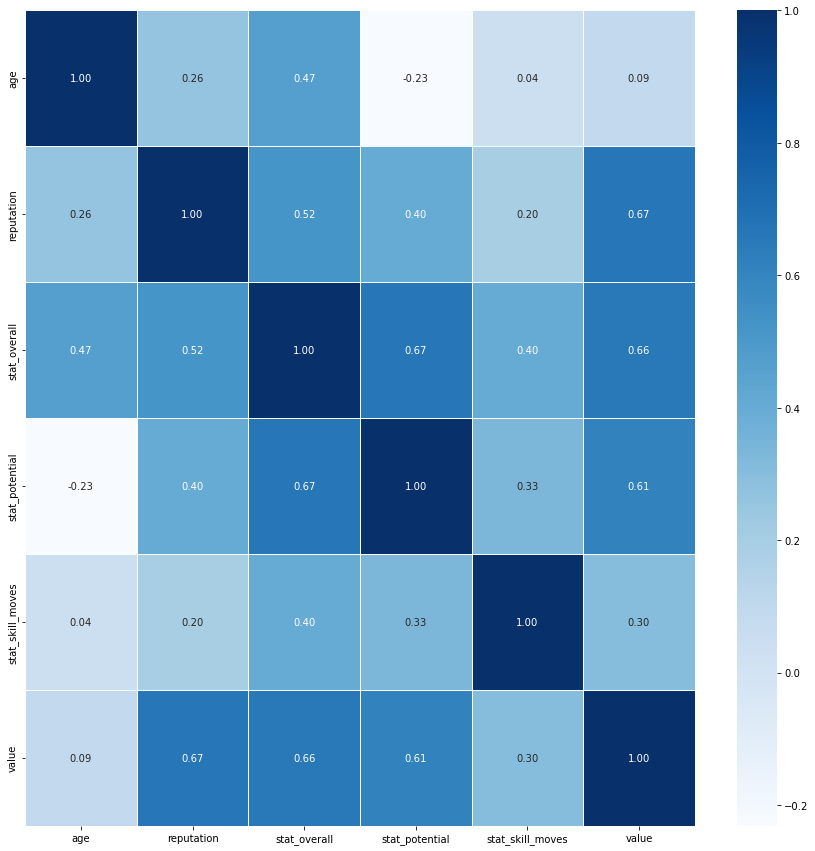

In [9]:
k = train[['age', 'continent', 'contract_until', 'position', 'prefer_foot',
       'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves',
       'value']]
plt.figure(figsize=(15,15))
sns.heatmap(data = k.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

Data 전처리

In [10]:
# train.contract_until.value_counts()

In [22]:
# 'contract_until' columns 통일시키는 함수

def value_change(train):
    year = []
    contract = []
    for i in train.contract_until.unique():
        
#         print(i)
#         print(len(i))
        if len(i) > 4:
#             print(i.split(','))
            a = i.split(' ')
            year.append(a)
            contract.append(i)
    for i, j in zip(contract, year):
#         print(i, j)
        train['contract_until'] = train['contract_until'].replace([i],j[2])
        

    return train.contract_until.unique()


value_change(train)


array(['2021', '2020', '2019', '2023', '2022', '2024', '2026', '2018',
       '2025'], dtype=object)

In [12]:
# train.contract_until.value_counts()

In [23]:
# Dtype change

print(train.info())
train = train.astype({'contract_until':'int16'})
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   continent         8932 non-null   object 
 2   contract_until    8932 non-null   object 
 3   position          8932 non-null   object 
 4   prefer_foot       8932 non-null   object 
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 697.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   contine

In [8]:
# One-Hot Encoder

train = pd.get_dummies(train, columns=['continent', 'position', 'prefer_foot', 'contract_until'])
train

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value,continent_africa,continent_asia,continent_europe,continent_oceania,...,prefer_foot_right,contract_until_2018,contract_until_2019,contract_until_2020,contract_until_2021,contract_until_2022,contract_until_2023,contract_until_2024,contract_until_2025,contract_until_2026
0,31,5.0,94,94,4.0,110500000.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,27,4.0,91,93,1.0,72000000.0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
2,31,5.0,91,91,3.0,80000000.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,32,4.0,91,91,3.0,51000000.0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,25,3.0,90,93,1.0,68000000.0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,18,1.0,48,63,3.0,60000.0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
8928,19,1.0,47,59,2.0,40000.0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
8929,18,1.0,47,64,2.0,50000.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
8930,18,1.0,47,65,1.0,50000.0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


In [15]:
# train.info()

In [24]:
train['continent'] = train['continent'].astype('category')
train['continent'] = train['continent'].cat.codes

train['position'] = train['position'].astype('category')
train['position'] = train['position'].cat.codes

train['prefer_foot'] = train['prefer_foot'].astype('category')
train['prefer_foot'] = train['prefer_foot'].cat.codes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   continent         8932 non-null   int8   
 2   contract_until    8932 non-null   int16  
 3   position          8932 non-null   int8   
 4   prefer_foot       8932 non-null   int8   
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int16(1), int64(3), int8(3)
memory usage: 462.4 KB


In [25]:
train['stat_skill_moves'] = train['stat_skill_moves'].astype(int)
train['stat_skill_moves'] = train['stat_skill_moves'].astype(int)

train['reputation'] = train['reputation'].astype(int)
train['reputation'] = train['reputation'].astype(int)

train

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,4,2021,3,0,5,94,94,4,110500000.0
1,27,2,2020,1,1,4,91,93,1,72000000.0
2,31,4,2021,3,1,5,91,91,3,80000000.0
3,32,2,2020,0,1,4,91,91,3,51000000.0
4,25,2,2021,1,1,3,90,93,1,68000000.0
...,...,...,...,...,...,...,...,...,...,...
8927,18,0,2019,2,1,1,48,63,3,60000.0
8928,19,2,2020,0,1,1,47,59,2,40000.0
8929,18,4,2021,0,1,1,47,64,2,50000.0
8930,18,2,2021,1,1,1,47,65,1,50000.0


In [18]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler객체 생성
mm = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
mm.fit(train[['age','stat_overall','stat_potential']])
train_ass = mm.transform(train[['age','stat_overall','stat_potential']])

In [19]:
train_ass = pd.DataFrame(train_ass)
train_ass.shape

(8932, 3)

In [20]:
del train['age']
del train['stat_overall']
del train['stat_potential']

In [21]:
train = pd.concat([train_ass, train], axis = 1)
train.shape

(8932, 10)

In [26]:
# test columns encoder

test['continent'] = test['continent'].astype('category')
test['continent'] = test['continent'].cat.codes

test['position'] = test['position'].astype('category')
test['position'] = test['position'].cat.codes

test['prefer_foot'] = test['prefer_foot'].astype('category')
test['prefer_foot'] = test['prefer_foot'].cat.codes
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   int8   
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   int8   
 6   prefer_foot       3828 non-null   int8   
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), int8(3), object(2)
memory usage: 250.6+ KB


In [27]:
test['stat_skill_moves'] = test['stat_skill_moves'].astype(int)
test['stat_skill_moves'] = test['stat_skill_moves'].astype(int)

test['reputation'] = test['reputation'].astype(int)
test['reputation'] = test['reputation'].astype(int)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                3828 non-null   int64 
 1   name              3828 non-null   object
 2   age               3828 non-null   int64 
 3   continent         3828 non-null   int8  
 4   contract_until    3828 non-null   object
 5   position          3828 non-null   int8  
 6   prefer_foot       3828 non-null   int8  
 7   reputation        3828 non-null   int64 
 8   stat_overall      3828 non-null   int64 
 9   stat_potential    3828 non-null   int64 
 10  stat_skill_moves  3828 non-null   int64 
dtypes: int64(6), int8(3), object(2)
memory usage: 250.6+ KB


In [23]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler객체 생성
mm = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
mm.fit(test[['age','stat_overall','stat_potential']])
test_ass = mm.transform(test[['age','stat_overall','stat_potential']])

In [24]:
test_ass = pd.DataFrame(test_ass)
test_ass.shape

(3828, 3)

In [25]:
del test['age']
del test['stat_overall']
del test['stat_potential']

In [26]:
test = pd.concat([test_ass, test], axis = 1)
test.shape

(3828, 11)

In [28]:
from sklearn import datasets, preprocessing

from sklearn.model_selection import train_test_split
import gc

X = train.drop(['value'], axis=1)
y = train['value']

# Apply standard scaling on x_data
sc = preprocessing.StandardScaler()
x_data = sc.fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0xC0FFEE)
# train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=0xC0FFEE)

# 6 : 2 : 2 = train : validation : test
print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)
gc.collect()

(7145, 9) (1787, 9) (7145,) (1787,)


0

modeling

In [24]:
# from sklearn.linear_model import LinearRegression as linear
# from sklearn.linear_model import Ridge as ridge
# from sklearn.linear_model import Lasso as lasso
# from lightgbm import LGBMRegressor as lgbm

# def fit_model(df) :
#   #그래프 그리는 함수
#     def constfig(pred, test, name):
#         d = test.reset_index()
#         d["pred"] = pred
#         d = d.sort_values("value").reset_index(drop=True)
        
#         fig = plt.figure(figsize = (15,8))
#         ax1 = fig.add_subplot(111)
        
#         sns.lineplot(x=d.index, y = d.value, data =d, label = "Original", ax=ax1, color='orange')
#         sns.scatterplot(x=d.index, y=d.pred, label = name, ax=ax1)
#         ax1.set_ylim([2,-2])
#         plt.title(f"{name} Prediction", fontsize=12)
#         plt.savefig(f"{name}_test_pred.png")
#     #예측
#     X = train.drop(['value'], axis=1)
#     y = train['value']
    
#     train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=589)
    
#     for model_func in [linear, ridge, lasso, lgbm]:
#       model_list = {linear:"LinearRegression", ridge:"RidgeRegression", lasso:"LassoRegression", lgbm:"LGBMRegression"}
#       print(f"\n{model_list[model_func]} Fitting...")
#       model = model_func().fit(train_X, train_y)
#       pred_val_y = model.predict(test_X)
#       pred_tr_y = model.predict(train_X)
#       print("train MAE : ",np.round(mean_absolute_error(pred_tr_y, train_y),6))
#       print("test MAE : ",np.round(mean_absolute_error(pred_val_y, test_y),6))
#       constfig(pred_val_y, test_y, model_list[model_func])

In [25]:
# fit_model(train)

In [29]:
from sklearn.linear_model import LinearRegression   # 1. Linear Regression
from sklearn.linear_model import Lasso              # 2. Lasso
from sklearn.linear_model import Ridge              # 3. Ridge
from xgboost.sklearn import XGBRegressor            # 4. XGBoost
from lightgbm.sklearn import LGBMRegressor          # 5. LightGBM
# from catboost import CatBoostRegressor              # 6. Catboost / SVR = X

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score


def Linear_training_mae(y, X):
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1511)
    model = LinearRegression().fit(train_X, train_y)
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)
    mae_train = mean_absolute_error(train_y, pred_train)
    mse_train = mean_squared_error(train_y, pred_train)
    mae_val = mean_absolute_error(val_y, pred_val)
    mse_val = mean_squared_error(val_y, pred_val)
    return print("Linear Regression\t train=%.4f, val=%.4f\t mse train=%.4f, val=%4.f" % (mae_train, mae_val, mse_train, mse_val))
def Lasso_training_mae(y, X):
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1511)
    model2 = Lasso().fit(train_X,train_y)
    pred_train2 = model2.predict(train_X)
    pred_val2 = model2.predict(val_X)
    mae_train2 = mean_absolute_error(train_y, pred_train2)
    mae_val2 = mean_absolute_error(val_y, pred_val2)
    return print("Lasso\t\t train=%.4f, val=%4.f" % (mae_train2, mae_val2))
def Ridge_training_mae(y, X):
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1511)
    model3 = Ridge().fit(train_X,train_y)
    pred_train3 = model3.predict(train_X)
    pred_val3 = model3.predict(val_X)
    mae_train3 = mean_absolute_error(train_y, pred_train3)
    mae_val3 = mean_absolute_error(val_y, pred_val3)
    return print("Ridge\t\t train=%.4f, val=%.4f" % (mae_train3, mae_val3))
def XGB_training_mae(y, X):
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1511)
    model4 = XGBRegressor().fit(train_X, train_y)
    pred_train4 = model4.predict(train_X)
    pred_val4 = model4.predict(val_X)
    mae_train4 = mean_absolute_error(train_y, pred_train4)
    mae_val4 = mean_absolute_error(val_y, pred_val4)
    return print("XGBoost\t\t train=%.4f, val=%.4f" % (mae_train4, mae_val4))
def LGBM_training_mae(y, X):
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1511)
    model5 = LGBMRegressor().fit(train_X, train_y)
    pred_train5 = model5.predict(train_X)
    pred_val5 = model5.predict(val_X)
    mae_train5 = mean_absolute_error(train_y, pred_train5)
    mae_val5 = mean_absolute_error(val_y, pred_val5)
    return print("LightGBM\t\t train=%.4f, val=%.4f" % (mae_train5, mae_val5))
# def CB_training_mae(y, X):
#     train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1511)
#     model6 = CatBoostRegressor(iterations=40, depth=16, learning_rate=1, loss_function='MAE').fit(train_X, train_y)
#     pred_train6 = model6.predict(train_X)
#     pred_val6 = model6.predict(val_X)
#     mae_train6 = mean_absolute_error(train_y, pred_train6)
#     mae_val6 = mean_absolute_error(val_y, pred_val6)
#     return print("CatBoost Regression \t\t train=%.4f, val=%.4f" % (mae_train6, mae_val6))

    
def AllModels_mae(y, X):
    print("Linaer training..")
    Linear = Linear_training_mae(y, X)
    print("Lasso training..")
    Lasso = Lasso_training_mae(y, X)
    print("Ridge training..")
    Ridge = Ridge_training_mae(y, X)
    print("XGBoost training..")
    XGB = XGB_training_mae(y, X)
    print("LightGBM training..")
    LGBM = LGBM_training_mae(y, X)
#     print("CatBoost training..")
#     CB = CB_training_mae(y, X)
    # return Linear, Lasso, Ridge, XGB, LGBM, CB

In [30]:
Linear_training_mae(y, X)

Linear Regression	 train=1859816.1734, val=1905866.0447	 mse train=11762622912788.1250, val=12532517256964


In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score


train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1511)
model = LinearRegression().fit(train_X, train_y)
pred_train = model.predict(train_X)
pred_val = model.predict(val_X)
mse_train = sqrt(mean_squared_error(train_y, pred_train))
mse_val = sqrt(mean_squared_error(val_y, pred_val))
# mse_train = r2_score(train_y, pred_train)
# mse_val = r2_score(val_y, pred_val)
print("Linear Regression\t  mse train=%.4f, val=%4.f" % (mse_train, mse_val))

Linear Regression	  mse train=3429668.0470, val=3540130


DL

In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Kears Logit 모델 fitting

In [17]:
train

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,4,2021,3,0,5,94,94,4,110500000.0
1,27,2,2020,1,1,4,91,93,1,72000000.0
2,31,4,2021,3,1,5,91,91,3,80000000.0
3,32,2,2020,0,1,4,91,91,3,51000000.0
4,25,2,2021,1,1,3,90,93,1,68000000.0
...,...,...,...,...,...,...,...,...,...,...
8927,18,0,2019,2,1,1,48,63,3,60000.0
8928,19,2,2020,0,1,1,47,59,2,40000.0
8929,18,4,2021,0,1,1,47,64,2,50000.0
8930,18,2,2021,1,1,1,47,65,1,50000.0


<AxesSubplot:>

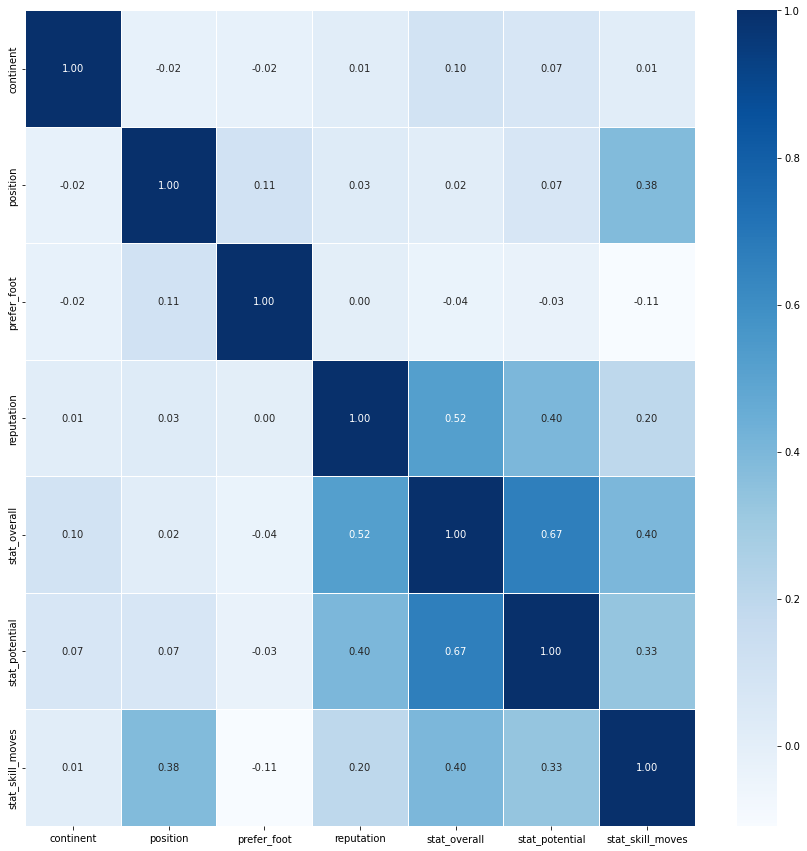

In [33]:
k = train[['continent', 'position', 'prefer_foot', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']]
plt.figure(figsize=(15,15))
sns.heatmap(data = k.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [34]:
y = train['value']
X = train[['continent', 'position', 'prefer_foot', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']]

In [35]:
model = Sequential()
model.add(Dense(14, activation='linear', input_shape=(7,)))
model.add(Dense(7, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [36]:
# Keras Model 살펴보기
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                112       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='-{epoch:03d}-{loss:.4f}-{accuracy:.4f}.hdf5',
            monitor='loss', verbose=1, save_best_only=True, mode='min')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [23]:
# model.fit(x=X, y=y, epochs=100, shuffle=True, batch_size=3, callbacks=CALLBACK)

Epoch 1/100
   1/2978 [..............................] - ETA: 7:04 - loss: -4396848.5000 - accuracy: 0.0000e+00

2022-07-08 20:54:50.205538: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2951/2978 [============================>.] - ETA: 0s - loss: -42343220.0000 - accuracy: 0.0000e+00
Epoch 1: loss improved from inf to -42372648.00000, saving model to -001--42372648.0000-0.0000.hdf5
2978/2978 [==============================] - 1s 377us/step - loss: -42372648.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/100
2857/2978 [===========================>..] - ETA: 0s - loss: -42188904.0000 - accuracy: 0.0000e+00
Epoch 2: loss improved from -42372648.00000 to -42372664.00000, saving model to -002--42372664.0000-0.0000.hdf5
2978/2978 [==============================] - 1s 371us/step - loss: -42372664.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/100
2862/2978 [===========================>..] - ETA: 0s - loss: -42338472.0000 - accuracy: 0.0000e+00
Epoch 3: loss improved from -42372664.00000 to -42372716.00000, saving model to -003--42372716.0000-0.0000.hdf5
2978/2978 [==============================] - 1s 371us/step - loss: -42372716.0000 - accuracy: 0.0000e+00 - lr: 0.0100
E

2978/2978 [==============================] - 1s 377us/step - loss: -42372652.0000 - accuracy: 0.0000e+00 - lr: 0.0021
Epoch 28/100
2848/2978 [===========================>..] - ETA: 0s - loss: -42456212.0000 - accuracy: 0.0000e+00
Epoch 28: loss did not improve from -42372720.00000

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.
2978/2978 [==============================] - 1s 370us/step - loss: -42372680.0000 - accuracy: 0.0000e+00 - lr: 0.0021
Epoch 29/100
2864/2978 [===========================>..] - ETA: 0s - loss: -42322840.0000 - accuracy: 0.0000e+00
Epoch 29: loss did not improve from -42372720.00000
2978/2978 [==============================] - 1s 368us/step - loss: -42372628.0000 - accuracy: 0.0000e+00 - lr: 0.0017
Epoch 30/100
2865/2978 [===========================>..] - ETA: 0s - loss: -42310256.0000 - accuracy: 0.0000e+00
Epoch 30: loss did not improve from -42372720.00000
2978/2978 [==============================] - 1s 368us/step - loss: -42372720

2860/2978 [===========================>..] - ETA: 0s - loss: -42531620.0000 - accuracy: 0.0000e+00
Epoch 54: loss did not improve from -42372760.00000
2978/2978 [==============================] - 1s 368us/step - loss: -42372660.0000 - accuracy: 0.0000e+00 - lr: 3.5184e-04
Epoch 55/100
2868/2978 [===========================>..] - ETA: 0s - loss: -42274940.0000 - accuracy: 0.0000e+00
Epoch 55: loss did not improve from -42372760.00000

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0002814749488607049.
2978/2978 [==============================] - 1s 368us/step - loss: -42372676.0000 - accuracy: 0.0000e+00 - lr: 3.5184e-04
Epoch 56/100
2965/2978 [============================>.] - ETA: 0s - loss: -42418900.0000 - accuracy: 0.0000e+00
Epoch 56: loss did not improve from -42372760.00000
2978/2978 [==============================] - 1s 373us/step - loss: -42372660.0000 - accuracy: 0.0000e+00 - lr: 2.8147e-04
Epoch 57/100
2863/2978 [===========================>..] - ETA: 0s - loss: -42

2975/2978 [============================>.] - ETA: 0s - loss: -42325840.0000 - accuracy: 0.0000e+00
Epoch 80: loss did not improve from -42372760.00000
2978/2978 [==============================] - 1s 371us/step - loss: -42372588.0000 - accuracy: 0.0000e+00 - lr: 4.7224e-05
Epoch 81/100
2959/2978 [============================>.] - ETA: 0s - loss: -42344604.0000 - accuracy: 0.0000e+00
Epoch 81: loss did not improve from -42372760.00000
2978/2978 [==============================] - 1s 374us/step - loss: -42372600.0000 - accuracy: 0.0000e+00 - lr: 4.7224e-05
Epoch 82/100
2848/2978 [===========================>..] - ETA: 0s - loss: -42342440.0000 - accuracy: 0.0000e+00
Epoch 82: loss did not improve from -42372760.00000

Epoch 82: ReduceLROnPlateau reducing learning rate to 3.777893143706024e-05.
2978/2978 [==============================] - 1s 370us/step - loss: -42372580.0000 - accuracy: 0.0000e+00 - lr: 4.7224e-05
Epoch 83/100
2974/2978 [============================>.] - ETA: 0s - loss: -42

In [38]:
# Model Load 하기 전, hdf5 File name 꼭 확인하기!

model.load_weights("-034--42372760.0000-0.0000.hdf5")

flask

In [39]:
from flask import Flask
from flask import Flask, render_template, request, url_for

In [40]:
app = Flask(__name__)

flask api 구현 구분

In [30]:
@app.route('/SpecialSale/<busy_day>/<high_temperature>')
def PredictionSpecialSale(busy_day=None, high_temperature=None):
    Input = pd.DataFrame({
        'busy_day':[int(busy_day)],
        'high_temperature':[float(high_temperature)]
    })
    
    return str(model.predict(Input)[0][0])

In [41]:
@app.route('/')
def index():
    return render_template('test2out.html')

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   continent         8932 non-null   int8 
 1   position          8932 non-null   int8 
 2   prefer_foot       8932 non-null   int8 
 3   reputation        8932 non-null   int64
 4   stat_overall      8932 non-null   int64
 5   stat_potential    8932 non-null   int64
 6   stat_skill_moves  8932 non-null   int64
dtypes: int64(4), int8(3)
memory usage: 305.4 KB


In [35]:
X.stat_potential.unique()

array([94, 93, 91, 90, 92, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78,
       77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61,
       60, 59, 58, 57, 56, 55, 54, 53, 52, 50, 48])

In [42]:
@app.route('/value', methods=['POST', 'GET'])
def calculate(out=None):
    ## 어떤 http method를 이용해서 전달받았는지를 아는 것이 필요함
    ## 아래에서 보는 바와 같이 어떤 방식으로 넘어왔느냐에 따라서 읽어들이는 방식이 달라짐
    if request.method == 'POST':
        #temp = request.form['num']
        pass
    elif request.method == 'GET':
        ## continent : 선수들의 국적이 포함되어 있는 대륙입니다
        continent = int(request.args.get('cont'))

        ## position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
        position = int(request.args.get('post'))
        
        ## prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
        prefer_foot = int(request.args.get('foot'))
        
        ## reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
        reputation = int(request.args.get('reput'))
        
        ## stat_overall : 선수의 현재 능력치 입니다.
        stat_overall = int(request.args.get('overall'))
        
        ## stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
        stat_potential = int(request.args.get('poten'))
        
        ## stat_skill_moves : 선수의 개인기 능력치 입니다.
        stat_skill_moves = int(request.args.get('skill'))
        

        Input = pd.DataFrame({
        'continent':[int(continent)],
        'position':[int(position)],
        'prefer_foot':[int(prefer_foot)],
        'reputation':[int(reputation)],
        'stat_overall':[int(stat_overall)],
        'stat_potential':[int(stat_potential)],
        'stat_skill_moves':[int(stat_skill_moves)]
        })
        out = str(model.predict(Input)[0][0])
        ## 넘겨받은 값을 원래 페이지로 리다이렉트
        return render_template('test2out.html', output=out)
    ## else 로 하지 않은 것은 POST, GET 이외에 다른 method로 넘어왔을 때를 구분하기 위함

Flask, port 5001으로 실행 (5000, macos 충돌)

In [ ]:
app.run(host='0.0.0.0', port=5001)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://10.186.23.34:5001 (Press CTRL+C to quit)
127.0.0.1 - - [08/Jul/2022 21:28:24] "GET / HTTP/1.1" 200 -
2022-07-08 21:28:34.480106: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
127.0.0.1 - - [08/Jul/2022 21:28:34] "GET /value?cont=0&post=0&foot=0&reput=4&overall=80&poten=80&skill=4 HTTP/1.1" 200 -


In [38]:
train_X.prefer_foot.unique()

array([0, 1], dtype=int8)